<a href="https://colab.research.google.com/github/Dianna22/NLP/blob/master/Project/Emocontext/keras_bilstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [0]:
!pip install emoji

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH_PREFIX = '/content/gdrive/My Drive/NLP/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import csv
import emoji
from keras import optimizers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from keras.models import Sequential, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from nltk.tokenize import TweetTokenizer
import numpy as np
import pandas as pd
import re
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import time
from matplotlib import pyplot as plt


In [0]:
# try:
#     from nltk.corpus import words
# except LookupError:
#     import nltk
#     print("Downloading nltk words...")
#     nltk.download("words")
#     from nltk.corpus import words

### Utils

#### Global Constants

In [0]:
TRAIN_FILE = PATH_PREFIX+'train.txt'
DEV_FILE =  PATH_PREFIX+'dev.txt'
TEST_FILE =  PATH_PREFIX+'test.txt'

TURNS_NAMES = ["turn1", "turn2", "turn3"]
LABEL = ["label"]
CONCATENATED_TURNS = "turns"

##### Emoticons map

In [0]:
EMOTICONS_MAP = {
    '😘': ' emoticon',
    '😍': ' happyemoticon',
    '😁': ' happyemoticon',
    '😭': ' sademoticon',
    '😑': ' sademoticon',
    '😻': ' happyemoticon',
    '😂': ' happyemoticon',
    '👍': ' emoticon',
    '😀': ' happyemoticon',
    ':D': ' happyemoticon',
    '🙂':  ' happyemoticon',
    '<3': ' happyemoticon',
    '😓' : ' sademoticon',
    '😒' : ' angryemoticon',
    '😈' : ' emoticon',
    '👿' : ' angryemoticon',
    '🖑' : ' happyemoticon',
    '😾' : ' emoticon',
    '😠' : ' angryemoticon',
    '👻' : ' emoticon',
    ':(' : ' sademoticon',
    ':)' : ' happyemoticon',
    'xD' : ' happyemoticon',
    '💔' : ' sademoticon',
    '😥' : ' emoticon',
    '😞' : ' sademoticon',
    '😤' : ' angryemoticon',
    '😃' : ' happyemoticon',
    '😦' : ' sademoticon',
    ':3' : ' emoticon',
    '😼' : ' emoticon',
    '😏' : ' happyemoticon',
    '😱' : ' sademoticon',
    '😬' : ' sademoticon',
    '🙁' : ' sademoticon',
    '</3' : ' sademoticon',
    '😺' : ' happyemoticon',
    '😣' : ' angryemoticon',
    '😢' : ' sademoticon',
    '😆' : ' happyemoticon',
    '😄' : ' happyemoticon',
    '😅' : ' happyemoticon',
    ':-)' : ' happyemoticon',
    '😊' : ' happyemoticon',
    '😕' : ' sademoticon',
    '😽' : ' happyemoticon',
    '🙀' : ' angryemoticon',
    '🤣' : ' happyemoticon',
    '🤐' : ' emoticon',
    '😡' : ' sademoticon',
    '👌' : ' happyemoticon', 
    '😮' : ' emoticon',
    '❤️' : ' happyemoticon',
    '🙄' : ' happyemoticon',
    '😿' : ' sademoticon',
    '😉' : ' happyemoticon',
    '😋' : ' happyemoticon',
    '😐' : ' emoticon',
    '😹' : ' happyemoticon',
    '😴' : ' sademoticon',
    '💤' : ' emoticon',
    '😜' : ' happyemoticon',
    '😇' : ' happyemoticon',
    '😔' : ' sademoticon',
    '😩' : ' sademoticon',
    '❤' : ' happyemoticon',
    '😲' : ' emoticon',
    '😫' : ' sademoticon',
    '😳' : ' sademoticon',
    '😰' : ' sademoticon',
}
print(len(EMOTICONS_MAP.keys()))

70


#### print_model

In [0]:
def print_model(model_summary, parameters, accuracy, file_name="models/experiments.txt"):
    with open(file_name, "a") as f:
        delimiter = "=============================================="
        acc_delim = "----------------------------------------------"
        format_string = "===Experiment===\n%s\n%s\n%s\n%s\n%s\n"
        f.write(format_string % (model_summary,
                                 delimiter,
                                 parameters,
                                 acc_delim,
                                 str(accuracy)))

#### Data manipulation

In [0]:
def parse_file(file_path):
    output_dict = dict()
    with open(file_path, newline='\n', encoding='utf8') as csvfile:
        return pd.read_csv(csvfile, sep="\t")

##### Load data

In [0]:
train_data = parse_file(TRAIN_FILE)
dev_data = parse_file(DEV_FILE)
test_data = parse_file(TEST_FILE)

##### Preprocess

In [0]:
def concatenate_turns(df, delim="fullstop"):
    turns = [("%s %s %s %s %s" %
                 (row[TURNS_NAMES[0]], delim,
                  row[TURNS_NAMES[1]], delim,
                  row[TURNS_NAMES[2]])).lower()
                 for index, row in df.iterrows()]
    df[CONCATENATED_TURNS] = pd.Series(turns, index=df.index)
    return df

In [0]:
def emoticons_replace(df):
    for index, row in df.iterrows():
        turns = emoji.demojize(row[CONCATENATED_TURNS])
        # remove delimiters ":"  (:smiley: -> smiley)
        for emoj in re.findall(":\w*:", turns):
            turns  = turns.replace(emoj, emoj[1:-1]).replace("_", " ")
        df.at[index, CONCATENATED_TURNS] = turns
    return df

In [0]:
# print(emoticons_replace(dev)["turns"][2])

In [0]:
tweet_tokenizer = TweetTokenizer()
def tokenize_turns(df):
    turns = [tweet_tokenizer.tokenize(row[CONCATENATED_TURNS]) 
                for idx, row in df.iterrows()]
    df[CONCATENATED_TURNS] = pd.Series(turns, index=df.index)
    return df

In [0]:
train = emoticons_replace(concatenate_turns(train_data))
dev = emoticons_replace(concatenate_turns(dev_data))
test = emoticons_replace(concatenate_turns(test_data))

In [0]:
# Ordinal encoding
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# print(le.fit(train[LABEL]))
# print(le.classes_)
# print(train[LABEL])
# print(le.transform(train[LABEL]))
# print(train[LABEL])

# One Hot encoding

In [0]:
max_sentence = 189 # 163,82,189
### angry: [1 0 0 0]
### happy: [0 1 0 0]
### others: [0 0 1 0]
### sad: [0 0 0 1]
labels = {0: 'angry',
          1: 'happy',
          2: 'others',
          3: 'sad'}

In [0]:
tokenizer = Tokenizer()
all_text = train[CONCATENATED_TURNS]
all_text = all_text.append(dev[CONCATENATED_TURNS])
all_text = all_text.append(test[CONCATENATED_TURNS])

# TODO
# alternative: fit_on_english corpora: 
# tokenizer.fit_on_texts(words.words())
tokenizer.fit_on_texts(all_text)
X_train = pad_sequences(tokenizer.texts_to_sequences(train[CONCATENATED_TURNS]),
                        maxlen=max_sentence)
X_dev = pad_sequences(tokenizer.texts_to_sequences(dev[CONCATENATED_TURNS]),
                      maxlen=max_sentence)
X_test = pad_sequences(tokenizer.texts_to_sequences(test[CONCATENATED_TURNS]),
                       maxlen=max_sentence)
### angry: [1 0 0 0]
### happy: [0 1 0 0]
### others: [0 0 1 0]
### sad: [0 0 0 1]
Y_train = pd.get_dummies(train[LABEL]).as_matrix()
# for i, t in enumerate(train[LABEL].iterrows()):
#     if t[1]['label']=='others':
#         print(Y_train[i])
#         break
Y_dev = pd.get_dummies(dev[LABEL]).as_matrix()
Y_test = pd.get_dummies(test[LABEL]).as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [0]:
# print(dir(tokenizer))

# for tok in tokenizer.word_count:
#     if tok[1] == 1:
#         print(tok)

#### Model

#### Model eval metrics

In [0]:
class Metrics(Callback):
    def __init__(self, test_X, test_Y, tolerance):
        self.test_X = test_X
        self.test_Y = test_Y
        self.max_f1 = 0
        self.f1_prev = 0
        self.tolerance = tolerance
        self.decreasing_times = 0
        
        
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        self.i = 0
        self.x = []
        
        self.f1s_test = []
        self.f1s_val = []
        self.losses = []
        self.val_losses = []
        
        self.logs = []
        self.fig = plt.figure()
    
    def plot_losses(self, f1_val,f1_test, logs):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.f1s_test.append(f1_test)
        self.f1s_val.append(f1_val)
        self.i += 1
        
#         clear_output(wait=True)
        
        plt.subplot(2,1,1)
        plt.plot(self.x, self.losses, label="train_loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.subplot(2,1,2)
        plt.plot(self.x, self.f1s_val, label="f1_val " + '{:.2f}'.format(max(self.f1s_val)))
        plt.plot(self.x, self.f1s_test, label="f1_test " + '{:.2f}'.format(max(self.f1s_test)))
        
        plt.legend(loc=0)

        plt.show();

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]

        _val_f1 = f1_score(val_targ, val_predict, average='micro')
        _val_recall = recall_score(val_targ, val_predict, average='micro')
        _val_precision = precision_score(val_targ, val_predict, average='micro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print("— val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        predicts = self.model.predict(self.test_X)
        test_predict = (np.asarray(predicts)).round()
        f1 = print_metrics_predicted(val_predict, val_targ)
        print("#############\nF1 test:\n#############")
        f_test = print_metrics_predicted(test_predict, self.test_Y)
        self.plot_losses(f1, f_test, logs)
        if f_test > self.max_f1:
            self.max_f1 = f_test
        if f_test < self.f1_prev:
            self.decreasing_times += 1
            if self.decreasing_times > self.tolerance:
                self.model.stop_training = True
        else:
            self.decreasing_times = 0
        self.f1_prev = f_test
        return
 
# metrics = Metrics()

def print_metrics_predicted(predicts,Y,filename=None):
    tp =[0,0,0,0]
    fp =[0,0,0,0]
    fn =[0,0,0,0]
    for i,pred in enumerate(predicts):
        p = np.argmax(pred)
        y = np.argmax(Y[i])
        if p == y:
            tp[p] += 1
        else:
            fp[p] +=1
            fn[y] +=1
    prec = sum(tp)/(sum(tp+fp)+np.finfo(float).eps)
    rec = sum(tp)/(sum(tp+fn)+np.finfo(float).eps)
    print("F1 all")
    f1_all = 2*prec*rec/(prec+rec+np.finfo(float).eps)
    print(f1_all) 
    print("***")
    for i in range(4):
      print("F1 %s: " % labels[i])
      prec = tp[i]/(tp[i]+fp[i]+np.finfo(float).eps)
      rec = tp[i]/(tp[i]+fn[i]+np.finfo(float).eps)
      f1 = 2*prec*rec/(prec+rec+np.finfo(float).eps)
      print(f1)
      print("****")
    tp.pop(2)
    fp.pop(2)
    fn.pop(2)
    print("F1 happy angry sad")
    prec = sum(tp)/(sum(tp+fp)+np.finfo(float).eps)
    rec = sum(tp)/(sum(tp+fn)+np.finfo(float).eps)
    f1= 2*prec*rec/(prec+rec+np.finfo(float).eps)
    print(f1)
    return f1


#### Model params

In [0]:
vocabulary_size = len(tokenizer.word_counts) + 1

epochs = 10
embed_dim = 256
lstm_out = 128
batch_size = 128
drop_out = 0.3
loss_fct = 'categorical_crossentropy'
activation_fct = 'softmax'
optimizer = "Adam-0.01"

parameters = """Epochs:%s\nEmbed_dim: %s\nLstm_out: %s\nBatch size: %s\nDrop_out: %s
Loss_fct: %s\nActivaion_fct: %s\nOptimizer: %s\n
""" %(str(epochs), str(embed_dim), str(lstm_out), str(batch_size), str(drop_out), loss_fct,
      activation_fct, optimizer)

#### Model train

In [0]:
model = Sequential()
model.add(Embedding(vocabulary_size, embed_dim,input_length = X_train.shape[1]))
model.add(Bidirectional(LSTM(lstm_out)))
model.add(Dropout(drop_out))
model.add(Dense(4,activation=activation_fct))
adam = optimizers.Adam(lr=0.01)
rmsprop = optimizers.RMSprop(lr=0.005)#, rho=0.9, epsilon=None, decay=0.0)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss = loss_fct, optimizer=adam, metrics = ['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 189, 256)          4698880   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 5,094,148
Trainable params: 5,094,148
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
MODEL_CHECKPOINT =  PATH_PREFIX+'models/1_emb-bilstm-emoji'

Instructions for updating:
Use tf.cast instead.
Train on 30160 samples, validate on 2755 samples
Epoch 1/50
30160/30160 [==============================] - 142s 5ms/step - loss: 0.4959 - acc: 0.8233 - val_loss: 0.3462 - val_acc: 0.8831
— val_f1: 0.882955 — val_precision: 0.889790 — val_recall 0.876225
F1 all
0.8773139745916514
***
F1 angry: 
0.605080831408776
****
F1 happy: 
0.7123287671232876
****
F1 others: 
0.9286190793862574
****
F1 sad: 
0.6527777777777777
****
F1 happy angry sad
0.6495557749259624
#############
F1 test:
#############
F1 all
0.8751134507170085
***
F1 angry: 
0.615566037735849
****
F1 happy: 
0.6631762652705059
****
F1 others: 
0.9282062680595687
****
F1 sad: 
0.6477462437395659
****
F1 happy angry sad
0.6386138613861386


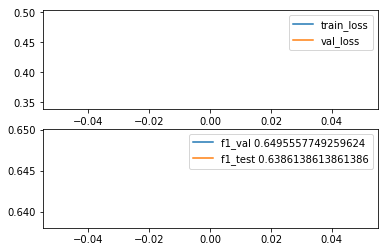

Epoch 2/50
30160/30160 [==============================] - 135s 4ms/step - loss: 0.2740 - acc: 0.9046 - val_loss: 0.3825 - val_acc: 0.8697
— val_f1: 0.869804 — val_precision: 0.877679 — val_recall 0.862069
F1 all
0.8646098003629763
***
F1 angry: 
0.58165548098434
****
F1 happy: 
0.699029126213592
****
F1 others: 
0.9206206431302001
****
F1 sad: 
0.6319218241042344
****
F1 happy angry sad
0.630291627469426
#############
F1 test:
#############
F1 all
0.8627700127064802
***
F1 angry: 
0.6011695906432748
****
F1 happy: 
0.6523887973640855
****
F1 others: 
0.9201930631945223
****
F1 sad: 
0.6151468315301389
****
F1 happy angry sad
0.6201991465149359


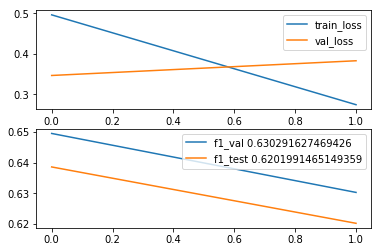

Epoch 3/50
30160/30160 [==============================] - 138s 5ms/step - loss: 0.2200 - acc: 0.9253 - val_loss: 0.4558 - val_acc: 0.8436
— val_f1: 0.841971 — val_precision: 0.846606 — val_recall 0.837387
F1 all
0.838475499092559
***
F1 angry: 
0.5664488017429192
****
F1 happy: 
0.6187845303867401
****
F1 others: 
0.902014652014652
****
F1 sad: 
0.6105919003115264
****
F1 happy angry sad
0.5954465849387038
#############
F1 test:
#############
F1 all
0.8366309675077145
***
F1 angry: 
0.5631929046563192
****
F1 happy: 
0.5904486251808971
****
F1 others: 
0.9029901848892945
****
F1 sad: 
0.5882352941176469
****
F1 happy angry sad
0.578900709219858


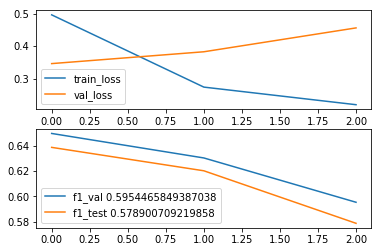

Epoch 4/50
30160/30160 [==============================] - 135s 4ms/step - loss: 0.1993 - acc: 0.9326 - val_loss: 0.4107 - val_acc: 0.8730
— val_f1: 0.872833 — val_precision: 0.877476 — val_recall 0.868240
F1 all
0.8693284936479128
***
F1 angry: 
0.5876543209876542
****
F1 happy: 
0.6749999999999999
****
F1 others: 
0.9235555555555555
****
F1 sad: 
0.6315789473684209
****
F1 happy angry sad
0.6277227722772276
#############
F1 test:
#############
F1 all
0.87220911236159
***
F1 angry: 
0.6245259165613147
****
F1 happy: 
0.6359143327841844
****
F1 others: 
0.9256180024387539
****
F1 sad: 
0.6343906510851418
****
F1 happy angry sad
0.630946419629444


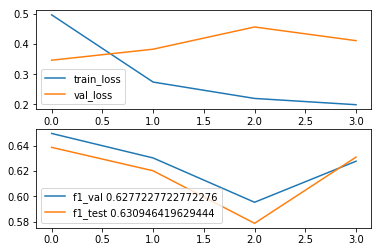

Epoch 5/50
30160/30160 [==============================] - 136s 5ms/step - loss: 0.1902 - acc: 0.9369 - val_loss: 0.4273 - val_acc: 0.8722
— val_f1: 0.872449 — val_precision: 0.875960 — val_recall 0.868966
F1 all
0.87005444646098
***
F1 angry: 
0.5901639344262294
****
F1 happy: 
0.664576802507837
****
F1 others: 
0.9243098842386462
****
F1 sad: 
0.6544117647058822
****
F1 happy angry sad
0.6306483300589389
#############
F1 test:
#############
F1 all
0.87420584498094
***
F1 angry: 
0.626387176325524
****
F1 happy: 
0.6304
****
F1 others: 
0.9278899489682714
****
F1 sad: 
0.6443661971830984
****
F1 happy angry sad
0.6327345309381237


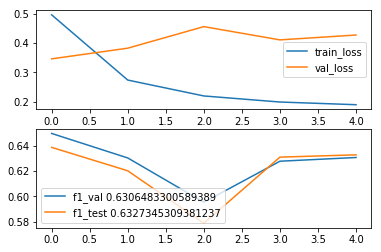

Epoch 6/50
30160/30160 [==============================] - 137s 5ms/step - loss: 0.1990 - acc: 0.9323 - val_loss: 0.4397 - val_acc: 0.8679
— val_f1: 0.867421 — val_precision: 0.872841 — val_recall 0.862069
F1 all
0.8635208711433756
***
F1 angry: 
0.5971563981042652
****
F1 happy: 
0.627906976744186
****
F1 others: 
0.9199463327370303
****
F1 sad: 
0.6470588235294116
****
F1 happy angry sad
0.6204238921001926
#############
F1 test:
#############
F1 all
0.8671265202396078
***
F1 angry: 
0.6263603385731559
****
F1 happy: 
0.5973254086181277
****
F1 others: 
0.9228191667597453
****
F1 sad: 
0.6584070796460176
****
F1 happy angry sad
0.6256658595641645


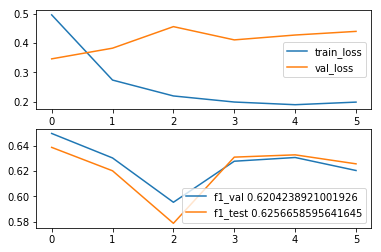

Epoch 7/50
30160/30160 [==============================] - 135s 4ms/step - loss: 0.1898 - acc: 0.9355 - val_loss: 0.4844 - val_acc: 0.8552
— val_f1: 0.854326 — val_precision: 0.859346 — val_recall 0.849365
F1 all
0.849364791288566
***
F1 angry: 
0.5676274944567626
****
F1 happy: 
0.6666666666666666
****
F1 others: 
0.9107789855072463
****
F1 sad: 
0.5814696485623002
****
F1 happy angry sad
0.6014625228519195
#############
F1 test:
#############
F1 all
0.8458885460156107
***
F1 angry: 
0.5995316159250585
****
F1 happy: 
0.5955555555555554
****
F1 others: 
0.908493771234428
****
F1 sad: 
0.5827010622154779
****
F1 happy angry sad
0.5932358318098719


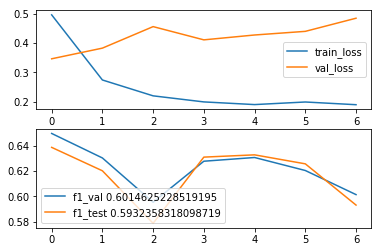

Epoch 8/50
30160/30160 [==============================] - 137s 5ms/step - loss: 0.1822 - acc: 0.9396 - val_loss: 0.3995 - val_acc: 0.8817
— val_f1: 0.881677 — val_precision: 0.885714 — val_recall 0.877677
F1 all
0.8791288566243193
***
F1 angry: 
0.6180048661800485
****
F1 happy: 
0.6644736842105262
****
F1 others: 
0.930242825607064
****
F1 sad: 
0.6566037735849055
****
F1 happy angry sad
0.6428571428571427
#############
F1 test:
#############
F1 all
0.871664548919949
***
F1 angry: 
0.6142506142506141
****
F1 happy: 
0.605128205128205
****
F1 others: 
0.9263553052887268
****
F1 sad: 
0.6405693950177934
****
F1 happy angry sad
0.6190719020907699


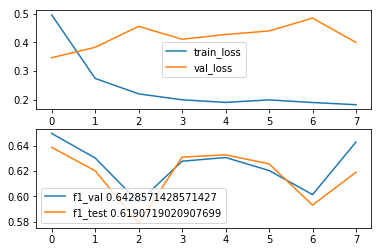

Epoch 9/50
30160/30160 [==============================] - 136s 5ms/step - loss: 0.1959 - acc: 0.9334 - val_loss: 0.4425 - val_acc: 0.8737
— val_f1: 0.873861 — val_precision: 0.877700 — val_recall 0.870054
F1 all
0.8711433756805806
***
F1 angry: 
0.6408268733850129
****
F1 happy: 
0.6666666666666665
****
F1 others: 
0.9246208742194467
****
F1 sad: 
0.5986394557823128
****
F1 happy angry sad
0.6374269005847953
#############
F1 test:
#############
F1 all
0.856598293701216
***
F1 angry: 
0.63841059602649
****
F1 happy: 
0.562146892655367
****
F1 others: 
0.9160049211497593
****
F1 sad: 
0.5993485342019542
****
F1 happy angry sad
0.6008666345690901


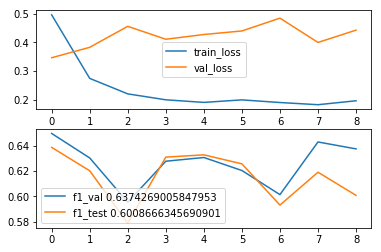

Epoch 10/50
30160/30160 [==============================] - 138s 5ms/step - loss: 0.2145 - acc: 0.9264 - val_loss: 0.4251 - val_acc: 0.8744
— val_f1: 0.873291 — val_precision: 0.877289 — val_recall 0.869328
F1 all
0.870780399274047
***
F1 angry: 
0.5952380952380951
****
F1 happy: 
0.6623376623376622
****
F1 others: 
0.9245115452930728
****
F1 sad: 
0.6474820143884892
****
F1 happy angry sad
0.6302186878727633
#############
F1 test:
#############
F1 all
0.8633145761481211
***
F1 angry: 
0.5934861278648974
****
F1 happy: 
0.6230031948881788
****
F1 others: 
0.9206950323011805
****
F1 sad: 
0.6222222222222221
****
F1 happy angry sad
0.6107843137254901


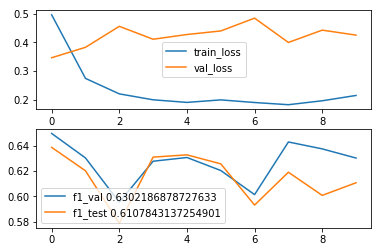

Epoch 11/50
30160/30160 [==============================] - 138s 5ms/step - loss: 0.1887 - acc: 0.9374 - val_loss: 0.4419 - val_acc: 0.8762
— val_f1: 0.875707 — val_precision: 0.880690 — val_recall 0.870780
F1 all
0.8725952813067149
***
F1 angry: 
0.5873786407766989
****
F1 happy: 
0.6791277258566977
****
F1 others: 
0.9264934488119031
****
F1 sad: 
0.6423357664233575
****
F1 happy angry sad
0.631578947368421
#############
F1 test:
#############
F1 all
0.8658558722091122
***
F1 angry: 
0.6070991432068543
****
F1 happy: 
0.596546310832025
****
F1 others: 
0.9226666666666666
****
F1 sad: 
0.6382978723404253
****
F1 happy angry sad
0.612487611496531


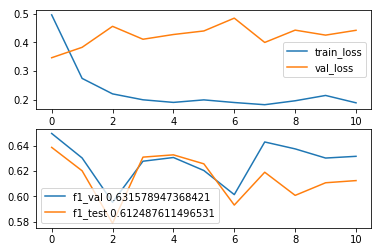

Epoch 12/50
30160/30160 [==============================] - 138s 5ms/step - loss: 0.1866 - acc: 0.9378 - val_loss: 0.4536 - val_acc: 0.8653
— val_f1: 0.867263 — val_precision: 0.872520 — val_recall 0.862069
F1 all
0.8631578947368421
***
F1 angry: 
0.6093023255813953
****
F1 happy: 
0.6299694189602445
****
F1 others: 
0.9196688297158201
****
F1 sad: 
0.6267605633802816
****
F1 happy angry sad
0.6205571565802113
#############
F1 test:
#############
F1 all
0.8546015610818659
***
F1 angry: 
0.5741399762752074
****
F1 happy: 
0.5962732919254657
****
F1 others: 
0.9160134378499439
****
F1 sad: 
0.6123128119800332
****
F1 happy angry sad
0.5919540229885056


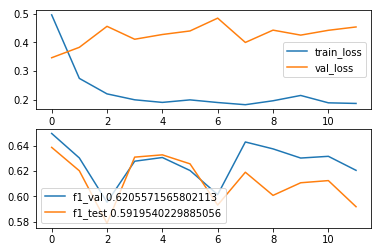

Epoch 13/50
30160/30160 [==============================] - 137s 5ms/step - loss: 0.1729 - acc: 0.9417 - val_loss: 0.4258 - val_acc: 0.8777
— val_f1: 0.877845 — val_precision: 0.880570 — val_recall 0.875136
F1 all
0.8758620689655171
***
F1 angry: 
0.6129870129870127
****
F1 happy: 
0.6498422712933752
****
F1 others: 
0.9274211339069048
****
F1 sad: 
0.6545454545454545
****
F1 happy angry sad
0.6366427840327532
#############
F1 test:
#############
F1 all
0.8680341259756761
***
F1 angry: 
0.6157894736842103
****
F1 happy: 
0.5972006220839813
****
F1 others: 
0.9239960172585463
****
F1 sad: 
0.6249999999999998
****
F1 happy angry sad
0.6124305204648811


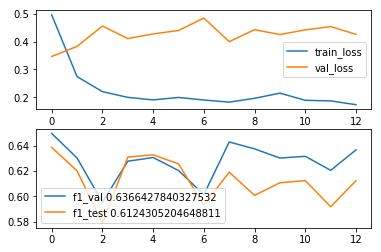

Epoch 14/50
30160/30160 [==============================] - 138s 5ms/step - loss: 0.1640 - acc: 0.9449 - val_loss: 0.4887 - val_acc: 0.8621
— val_f1: 0.862609 — val_precision: 0.866081 — val_recall 0.859165
F1 all
0.8591651542649726
***
F1 angry: 
0.5833333333333331
****
F1 happy: 
0.613095238095238
****
F1 others: 
0.9179521573887769
****
F1 sad: 
0.6279863481228668
****
F1 happy angry sad
0.605593056894889
#############
F1 test:
#############
F1 all
0.8564167725540023
***
F1 angry: 
0.6136363636363635
****
F1 happy: 
0.5744680851063829
****
F1 others: 
0.9163034975974969
****
F1 sad: 
0.6009693053311792
****
F1 happy angry sad
0.5973900434992749


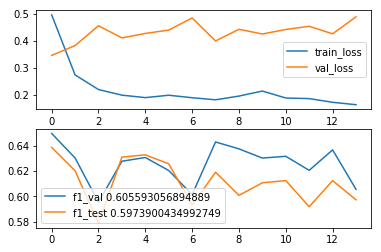

Epoch 15/50
30160/30160 [==============================] - 137s 5ms/step - loss: 0.1669 - acc: 0.9435 - val_loss: 0.5161 - val_acc: 0.8508
— val_f1: 0.850784 — val_precision: 0.855152 — val_recall 0.846461
F1 all
0.8471869328493646
***
F1 angry: 
0.6028037383177568
****
F1 happy: 
0.5879265091863516
****
F1 others: 
0.9093387866394002
****
F1 sad: 
0.6133333333333333
****
F1 happy angry sad
0.6005410279531108
#############
F1 test:
#############
F1 all
0.8486113632238155
***
F1 angry: 
0.5992691839220462
****
F1 happy: 
0.5762711864406778
****
F1 others: 
0.9115492957746477
****
F1 sad: 
0.5863192182410423
****
F1 happy angry sad
0.5879608026131591


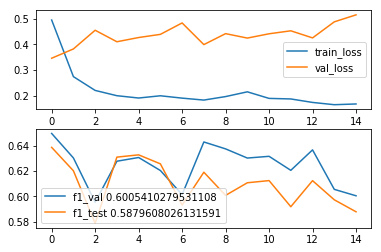

Epoch 16/50
30160/30160 [==============================] - 139s 5ms/step - loss: 0.1623 - acc: 0.9440 - val_loss: 0.4898 - val_acc: 0.8613
— val_f1: 0.862409 — val_precision: 0.867156 — val_recall 0.857713
F1 all
0.8591651542649726
***
F1 angry: 
0.6186046511627906
****
F1 happy: 
0.59214501510574
****
F1 others: 
0.9175257731958762
****
F1 sad: 
0.6202090592334493
****
F1 happy angry sad
0.6106870229007634
#############
F1 test:
#############
F1 all
0.8593211109094209
***
F1 angry: 
0.5982694684796043
****
F1 happy: 
0.6177370030581039
****
F1 others: 
0.9183696259073142
****
F1 sad: 
0.5933333333333332
****
F1 happy angry sad
0.6030053320407173


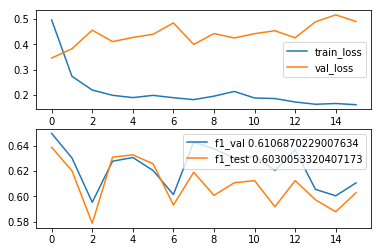

Epoch 17/50
30160/30160 [==============================] - 139s 5ms/step - loss: 0.1648 - acc: 0.9436 - val_loss: 0.4970 - val_acc: 0.8599
— val_f1: 0.860164 — val_precision: 0.864103 — val_recall 0.856261
F1 all
0.8566243194192376
***
F1 angry: 
0.616867469879518
****
F1 happy: 
0.6224783861671469
****
F1 others: 
0.9160099076784508
****
F1 sad: 
0.5863192182410423
****
F1 happy angry sad
0.6099158091674461
#############
F1 test:
#############
F1 all
0.8595026320566345
***
F1 angry: 
0.6159600997506234
****
F1 happy: 
0.5958702064896754
****
F1 others: 
0.9191184696274751
****
F1 sad: 
0.5943238731218696
****
F1 happy angry sad
0.603174603174603


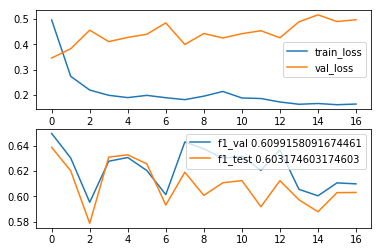

Epoch 18/50
30160/30160 [==============================] - 137s 5ms/step - loss: 0.1668 - acc: 0.9418 - val_loss: 0.4585 - val_acc: 0.8701
— val_f1: 0.869993 — val_precision: 0.872853 — val_recall 0.867151
F1 all
0.8671506352087113
***
F1 angry: 
0.6389610389610388
****
F1 happy: 
0.6309523809523808
****
F1 others: 
0.9223560910307899
****
F1 sad: 
0.6058631921824102
****
F1 happy angry sad
0.6264591439688715
#############
F1 test:
#############
F1 all
0.8605917589399164
***
F1 angry: 
0.6157894736842103
****
F1 happy: 
0.60625
****
F1 others: 
0.919501890148988
****
F1 sad: 
0.5705128205128205
****
F1 happy angry sad
0.5988142292490118


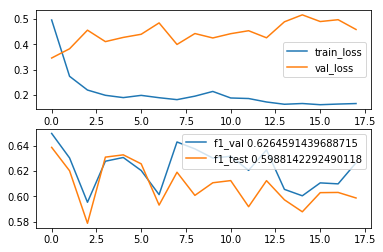

Epoch 19/50
 2048/30160 [=>............................] - ETA: 2:02 - loss: 0.1464 - acc: 0.9521

KeyboardInterrupt: ignored

In [0]:
model.fit(X_train, Y_train, epochs=50, verbose=1, batch_size=batch_size,
          validation_data=(X_dev, Y_dev),
          callbacks=[Metrics(X_test, Y_test, 3)
                    ])
#63

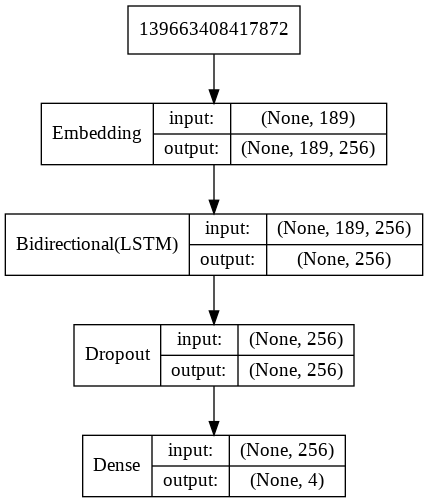

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras
import IPython
# SVG(model_to_dot(model).create(prog='dot', format='svg'))
keras.utils.plot_model(model, to_file='test_keras_plot_model.png', show_shapes=True,show_layer_names=False)
IPython.display.Image('test_keras_plot_model.png')

#### Model eval

In [0]:
# results = model.evaluate(X_test, Y_test, callbacks=[metrics])

In [0]:
# print(results)
# print(model.metrics_names)

In [0]:
# f1 = print_metrics(model, X_test, Y_test, OPTS_PATH)
# print(f1)

0.6213307240704501


#### Model save & load

In [0]:
OPTS_PATH = 'models/1_opts-emb-bilstm-dr-dense'

In [0]:
MODEL_PATH = '%s-%s.json' % (MODEL_CHECKPOINT, str(f1))
MODEL_W_PATH = '%s-%s.h5' % (MODEL_CHECKPOINT, str(f1))

NameError: name 'f1' is not defined

In [0]:
with open(OPTS_PATH, 'w') as f:
    f.write(str(model.get_config()))
    f.write("\n%s" % parameters)

In [0]:
model.save(MODEL_PATH)

In [0]:
def load_saved_model(model_path):
    return load_model(model_path)

In [0]:
loaded_model = load_model(MODEL_PATH)

In [0]:
loaded_model = load_model('models/1_emb-bilstm-dr-dense-0.6213307240704501.json')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


f:\python 36 64\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
f1 = print_metrics(loaded_model, X_test, Y_test, OPTS_PATH)
print(f1)

0.6213307240704501


In [0]:
print(np.shape(X_train))
print(np.shape(Y_train))

print(np.shape(X_dev))

print(np.shape(Y_dev))


print(np.shape(X_test))

print(np.shape(Y_test))


(30160, 163)
(30160, 4)
(2755, 82)
(2755, 4)
(5509, 189)
(5509, 4)


In [0]:
# y_true = [[0,0,0,1], [0,1,0,0], [1,0,0,0]]
# y_pred = [[0,0,0,1], [1,0,0,0], [1,0,0,0]]
# # print(f1_score(y_true, y_pred, average='macro'))
# print(f1_score(y_true, y_pred, average='micro')) 
# # print(f1_score(y_true, y_pred, average='weighted')) 
# # print(f1_score(y_true, y_pred, average='samples')) 

ValueError: multiclass-multioutput is not supported

In [0]:
import inspect as i
import sys
sys.stdout.write(i.getsource(model.evaluate))